# Challenge: Model Comparison

## Dataset Selection and Extraction

In [47]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [59]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
weather_df = pd.read_sql_query('SELECT * FROM weatherinszeged', con=engine)

#Close the connection after query is complete
engine.dispose()

In [4]:
weather_df.columns

Index(['date', 'summary', 'preciptype', 'temperature', 'apparenttemperature',
       'humidity', 'windspeed', 'windbearing', 'visibility', 'loudcover',
       'pressure', 'dailysummary'],
      dtype='object')

In [15]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Data Cleaning

In [60]:
#Split date feature into usable features: hour, day, month, and year
day = []
month = []
year = []
hour = []
for date in weather_df['date']:
    year.append(int(str(date).split('-')[0]))
    month.append(int(str(date).split('-')[1]))
    day.append(int(str(date).split('-')[2].split(' ')[0]))
    hour.append(int(str(date).split(' ')[1].split(':')[0]))
    
weather_df['year'] = year
weather_df['month'] = month
weather_df['day'] = day
weather_df['hour'] = hour

In [61]:
#Drop columns that are not useful for regression
weather_df = weather_df.drop(['date', 'summary', 'preciptype', 'loudcover', 'dailysummary'], axis = 1)

In [33]:
#Check updated dataframe
weather_df.head()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,year,month,day,hour
0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,2006,3,31,22
1,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,2006,3,31,23
2,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,2006,4,1,0
3,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,2006,4,1,1
4,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,2006,4,1,2


## Feature Selection

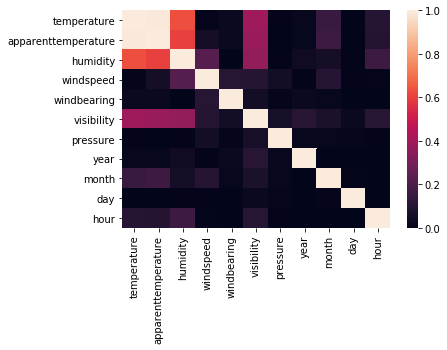

In [40]:
#Find the correlation between the existing features to see if we need to drop any
plt.figure()
sns.heatmap(abs(weather_df.corr()))
plt.show()

As we can see in the heatmap, temperature and apparenttemperature are very highly correlated with each other. Additionally, both temperature features are pretty highly correlated with humidity. Therefore, we should drop apparenttemperature, since it's extraneous when compared with the temperature feature.

In [44]:
weather_df = weather_df.drop('apparenttemperature', axis=1)

#Temperature is the target variable, everything else is a feature
headers = list(weather_df.columns)

features = weather_df.drop(columns = ['temperature'])
target = weather_df['temperature']

## Train-Test Split

In [48]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=250)

## OLS Regression Model

In [49]:
# Linear Regression Model
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## KNN Regression Model

In [51]:
# KNN model
knn = KNeighborsRegressor(n_neighbors=10, weights="distance")
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='distance')

## Compare Models via Cross-Validation

In [52]:
# Cross-Validation
knn_score = cross_val_score(knn, X_test, y_test, cv=5)
lm_score = cross_val_score(lm, X_test, y_test, cv=5)

#Compare accuracy scores
print("KNN had accuracy score of: %0.2f (+/- %0.4f)" % (knn_score.mean(), knn_score.std() * 2))
print("Linear Regression had accuracy score of: %0.2f (+/- %0.4f)" % (lm_score.mean(), lm_score.std() * 2))

KNN had accuracy score of: 0.49 (+/- 0.0182)
Linear Regression had accuracy score of: 0.48 (+/- 0.0229)


The models have similar accuracies. Let's check if normalizing the data improves the accuracy for either model.

## Scale Features Between 0 and 1

In [66]:
#Normalize the values between 0 and 1 (min-max scaling)
scaled_weather = pd.DataFrame()

for cat in weather_df.columns:
    normed = []
    minval = weather_df[cat].min()
    maxval = weather_df[cat].max()
    
    for i in range(len(weather_df[cat])):
        normed.append((weather_df[cat][i]-minval)/(maxval-minval))

    scaled_weather[cat] = normed

scaled_weather.head()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,pressure,year,month,day,hour
0,0.506975,0.523486,0.89,0.221130,0.699164,0.983,0.970135,0.090909,0.181818,1.0,0.956522
1,0.505085,0.521084,0.86,0.223399,0.721448,0.983,0.970613,0.090909,0.181818,1.0,1.000000
2,0.505445,0.553144,0.89,0.061523,0.568245,0.929,0.970909,0.090909,0.272727,0.0,0.000000
3,0.487805,0.501947,0.83,0.220877,0.749304,0.983,0.971358,0.090909,0.272727,0.0,0.043478
4,0.495365,0.517356,0.83,0.172970,0.721448,0.983,0.971454,0.090909,0.272727,0.0,0.086957


In [74]:
scaled_weather = scaled_weather.drop('apparenttemperature', axis=1)

#Temperature is the target variable, everything else is a feature
features = scaled_weather.drop(columns = ['temperature'])
target = scaled_weather['temperature']

## Train-Test Split

In [75]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=250)

## OLS Regression Model

In [76]:
# Linear Regression Model
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

## KNN Regression Model

In [77]:
# KNN model
knn = KNeighborsRegressor(n_neighbors=10, weights="distance")
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='distance')

## Compare Models via Cross-Validation

In [78]:
# Cross-Validation
knn_score = cross_val_score(knn, X_test, y_test, cv=5)
lm_score = cross_val_score(lm, X_test, y_test, cv=5)

#Compare accuracy scores
print("KNN had accuracy score of: %0.2f (+/- %0.4f)" % (knn_score.mean(), knn_score.std() * 2))
print("Linear Regression had accuracy score of: %0.2f (+/- %0.4f)" % (lm_score.mean(), lm_score.std() * 2))

KNN had accuracy score of: 0.85 (+/- 0.0071)
Linear Regression had accuracy score of: 0.48 (+/- 0.0229)


In [79]:
len(scaled_weather)

96453

After scaling the values, OLS Regression still has pretty low accuracy, but KNN Regression has improved drastically. The improved performance of KNN versus OLS is likely due to the high number of points in the dataset (almost 100,000 rows), which gives many possible neighbors with which to improve accuracy. Additionally, the features likely don't have a directly linear relationship, which is why OLS wasn't as effective.